In [1]:
import tensorflow
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import os

import warnings
warnings.filterwarnings('ignore')

### Path to dataset
### Reading Metadata.csv

In [2]:
# Read Data
audio_dataset_path =r"E:\Music_classification\Data\genres_original"
metadata = pd.read_csv(r'E:\Final 2Dataset2\metadata_clear.csv')
metadata = pd.read_csv(r'E:\Music_classification\Data\features_30_sec.csv')
metadata.head(5)

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


### Function to extract MFCC

In [3]:
# function to get mfcc from a file
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0) 

    return mfccs_scaled_features

### Just looking at the shape

In [4]:
file_name="E:\Music_classification\Data\genres_original\\rock\\rock.00017.wav"
ps=features_extractor(file_name)
ps.shape

(1293, 40)

### Put features and labels into a list

In [5]:
from tqdm import tqdm
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    #file_name = os.path.join(os.path.abspath(audio_dataset_path),str(row["filename"]).partition(".")[0],"/"+str(row["filename"]))
    final_class_labels = row["label"]
    file_name = os.path.join(os.path.abspath(audio_dataset_path),final_class_labels+"\\",str(row["filename"]))
    #print(file_name)
    data = features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

1000it [00:28, 35.70it/s]


### Converting extracted_features to Pandas dataframe

In [6]:
extracted_features_df = pd.DataFrame(extracted_features,columns=['feature','category'])
extracted_features_df.head(-1)

,feature,category
0,"[[-240.63542, 99.64764, -7.4032764, 37.47548, ...",blues
1,"[[-339.1464, 157.71887, 11.753511, 16.647871, ...",blues
2,"[[-92.80102, 147.20618, -52.905205, 13.748398,...",blues
3,"[[-220.65663, 180.66992, -1.9548075, 19.935938...",blues
4,"[[-281.78323, 143.18051, -26.93118, -4.125527,...",blues
...,...,...
994,"[[-96.279976, 108.227936, -49.246353, 49.78727...",rock
995,"[[-219.15886, 113.164505, -0.44539088, 68.1691...",rock
996,"[[-170.0446, 95.54274, -10.946112, 43.753654, ...",rock
997,"[[-190.12563, 124.486336, -47.929058, 51.34510...",rock


### Split the dataset into independent and dependent dataset

In [7]:
X = np.array(extracted_features_df['feature'].tolist()) # Input set
y = np.array(extracted_features_df['category'].tolist()) # Output set (predictions)

In [8]:
X.shape

(1000,)

In [9]:
y.shape

(1000,)

### Label Encoding

In [10]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [11]:
y.shape

(1000, 10)

### Train Test Split 20% for testing

In [12]:
from sklearn.model_selection import train_test_split

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

#print(x_train, x_val, x_test)

[array([[-1.42525192e+02,  8.32398758e+01, -6.81807251e+01, ...,
        -1.64963269e+00,  2.65254545e+00, -1.13510723e+01],
       [-1.13784210e+02,  8.12128677e+01, -7.57656937e+01, ...,
        -2.21121621e+00, -6.51280403e-01, -7.65118742e+00],
       [-1.20663216e+02,  7.63938293e+01, -7.75506592e+01, ...,
        -7.28975582e+00, -4.16451395e-01,  1.36628163e+00],
       ...,
       [-1.05162384e+02,  8.84315109e+01, -6.32589226e+01, ...,
         2.06332111e+00,  2.26545525e+00, -1.15213239e+00],
       [-1.14172775e+02,  8.31196060e+01, -6.03342743e+01, ...,
        -1.25927329e-01,  2.07400918e+00,  2.80283475e+00],
       [-1.17014519e+02,  7.52090988e+01, -5.30489883e+01, ...,
        -7.47631836e+00,  5.23003817e-01,  1.99868703e+00]], dtype=float32)
 array([[-144.88347  ,  105.44433  ,  -62.571877 , ...,   -6.3805532,
          -8.296716 ,    2.1810846],
       [-141.17297  ,  115.022415 ,  -57.59053  , ...,   -8.921331 ,
          -9.50399  ,    3.401198 ],
       [-208.5

### Function for plotting graphs

In [13]:
import matplotlib.pyplot as plt

In [14]:
def plot_history(history):
    
    fig, axs = plt.subplots(2,constrained_layout=True)

    #create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    #create error subplot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

### Defining Model

# ANN

In [13]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(10)) ## We have 10 classes rock,jazz,blues.....
model.add(Activation('softmax'))

In [ ]:
model.summary()

### Training with model

Epoch 1/300
6/6 [==============================] - 1s 23ms/step - loss: 31.3987 - accuracy: 0.0907 - val_loss: 6.1601 - val_accuracy: 0.1700

Epoch 00001: val_loss improved from inf to 6.16014, saving model to saved_models\audio_classification.hdf5
Epoch 2/300
6/6 [==============================] - 0s 4ms/step - loss: 20.6560 - accuracy: 0.0987 - val_loss: 4.8480 - val_accuracy: 0.1900

Epoch 00002: val_loss improved from 6.16014 to 4.84799, saving model to saved_models\audio_classification.hdf5
Epoch 3/300
6/6 [==============================] - 0s 4ms/step - loss: 14.3493 - accuracy: 0.1173 - val_loss: 3.0417 - val_accuracy: 0.2000

Epoch 00003: val_loss improved from 4.84799 to 3.04175, saving model to saved_models\audio_classification.hdf5
Epoch 4/300
6/6 [==============================] - 0s 4ms/step - loss: 10.9668 - accuracy: 0.1187 - val_loss: 2.4010 - val_accuracy: 0.2000

Epoch 00004: val_loss improved from 3.04175 to 2.40102, saving model to saved_models\audio_classification.

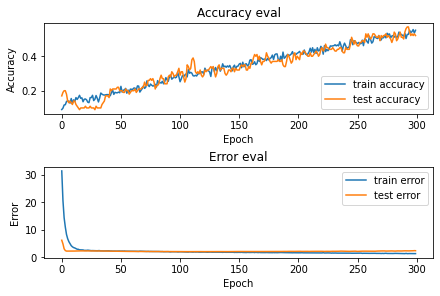

4/4 [==============================] - 0s 2ms/step - loss: 2.3484 - accuracy: 0.5200
Test loss: 2.348447799682617
Test accuracy: 0.5199999809265137
Training completed in time:  0:00:10.268872


In [14]:
#optimizer = tensorflow.keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer="adam")

## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime 

num_epochs = 300
num_batch_size = 128

keras_callbacks = [
	 EarlyStopping(monitor='val_loss', patience=5, mode='min', min_delta=0.01),
	 ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', monitor='val_loss',
                               verbose=1, save_best_only=True, mode='min')
]


start = datetime.now()

#history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=keras_callbacks, verbose=1)
history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', monitor='val_loss',
                               verbose=1, save_best_only=True, mode='min')
], verbose=1)
plot_history(history)

score = model.evaluate(
	x_test,
	y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

duration = datetime.now() - start
print("Training completed in time: ", duration)

### Confusion matrix on validation set

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

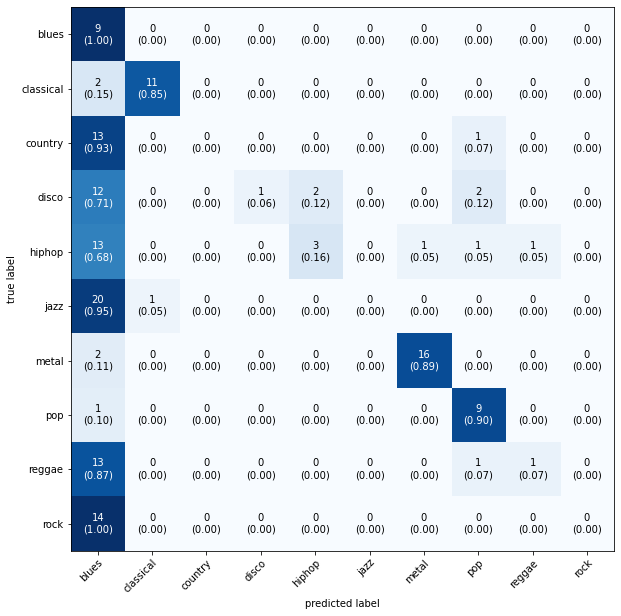

In [19]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

y_pred = (model.predict(x_val) > 0.5).astype("int32")
class_names=["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]

mat=confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))

plot_confusion_matrix(conf_mat=mat,class_names=class_names,show_normed=True,figsize=(10,10))

### Validation Accuracy

In [21]:
score = model.evaluate(
	x_val,
	y_val)

print('val loss:', score[0])
print('val accuracy:', score[1])

5/5 [==============================] - 0s 2ms/step - loss: 1.5041 - accuracy: 0.5267
val loss: 1.5040749311447144
val accuracy: 0.5266666412353516
